In [ ]:
import torch 
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/NYCTaxiFares.csv')

In [ ]:
df

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1
...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03 UTC,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1
119996,2010-04-23 10:27:48 UTC,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1
119997,2010-04-18 18:50:40 UTC,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3
119998,2010-04-13 08:14:44 UTC,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1


In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [ ]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [ ]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour

In [ ]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [ ]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount'] 

In [ ]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')


In [ ]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [ ]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [ ]:
df['AMorPM'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [ ]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkday = df['Weekday'].cat.codes.values

In [ ]:
cats = np.stack([hr,ampm,wkday],axis=1)

In [ ]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [ ]:
cats = torch.tensor(cats,dtype=torch.int64)

In [ ]:
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

NOTE: This can be done in one line of code using a list comprehension:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.

In [ ]:
conts = np.stack([df[cont].values for cont in cont_cols],1)

In [ ]:
conts

array([[ 40.730521  , -73.992365  ,  40.744746  , -73.975499  ,
          1.        ,   2.12631159],
       [ 40.740558  , -73.990078  ,  40.744114  , -73.974232  ,
          1.        ,   1.39230687],
       [ 40.751118  , -73.994149  ,  40.766235  , -73.960064  ,
          2.        ,   3.32676344],
       ...,
       [ 40.749772  , -73.988574  ,  40.707799  , -74.011541  ,
          3.        ,   5.05252282],
       [ 40.724529  , -74.004449  ,  40.730765  , -73.992697  ,
          1.        ,   1.20892296],
       [ 40.77192   , -73.955415  ,  40.763015  , -73.967623  ,
          3.        ,   1.42739869]])

In [ ]:
conts = torch.tensor(conts,dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [ ]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [ ]:
cats.shape

torch.Size([120000, 3])

In [ ]:
conts.shape

torch.Size([120000, 6])

In [ ]:
y.shape

torch.Size([120000, 1])

In [ ]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [ ]:
cat_szs

[24, 2, 7]

In [ ]:
emd_szs = [(size,min(50,size+1)//2) for size in cat_szs]

In [ ]:
emd_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
embeddz = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emd_szs])

In [ ]:
embeddz

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [ ]:
catz = cats[:4]

In [ ]:
catz[:,1]

tensor([0, 0, 0, 1])

In [ ]:
embeddingz = []
for i,e in enumerate(embeddz):
    embeddingz.append(e(catz[:,i]))

embeddingz

[tensor([[ 0.3624, -0.0193,  1.4311,  0.7699,  0.6380, -0.5086,  0.3775, -0.9105,
          -0.6404,  0.0811,  2.2934, -0.2123],
         [ 0.3770,  1.2864,  0.1850,  1.0744, -1.7405,  0.4319, -0.7893,  0.5637,
          -1.5678, -1.5526, -2.0128, -0.7488],
         [-0.8913,  2.3388,  0.5483, -1.6183, -0.3928, -0.5593, -0.6220,  1.2499,
          -0.5345, -0.3093, -0.6893,  1.2658],
         [ 0.3149, -0.6563,  0.1784, -0.0985, -0.4281, -0.1047, -0.4964,  1.0420,
          -0.4158, -0.1209,  0.4946, -0.4278]], grad_fn=<EmbeddingBackward>),
 tensor([[0.2222],
         [0.2222],
         [0.2222],
         [1.6512]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.6729, -0.0893, -1.4773, -1.5746],
         [-0.5428, -1.6489, -1.0231, -0.4406],
         [-0.5428, -1.6489, -1.0231, -0.4406],
         [ 0.6306,  0.4981,  0.7456,  1.1061]], grad_fn=<EmbeddingBackward>)]

In [ ]:
z = torch.cat(embeddingz,1)

In [ ]:
z.shape

torch.Size([4, 17])

In [ ]:
class TabularModel(nn.Module):

  def __init__(self,emd_szs, n_cont,out_sz,layers,p=0.5):
    super().__init__()

    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emd_szs])
    self.embed_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_cont)

    layerlist = []
    n_embed = sum((nf for ni,nf in emd_szs))
    n_in = n_embed + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in,i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i
    
    layerlist.append(nn.Linear(layers[-1],out_sz))

    self.layers  = nn.Sequential(*layerlist)

  def forward(self,x_cat,x_cont):
    embeddings = []

    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:,i]))
    
    x = torch.cat(embeddings,1)
    x = self.embed_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)

    x = self.layers(x)

    return x
    

In [ ]:
torch.manual_seed(33)
model = TabularModel(emd_szs, conts.shape[1], 1, [200,100], p=0.4)

In [ ]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (embed_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
batch_size = 60000
test_size = int(batch_size*.2)

In [ ]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:test_size]

cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:test_size]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:test_size]

In [ ]:
epochs = 500

losses = []

for i in range(epochs):
  i += 1 
  y_pred = model(cat_train,cont_train)
  loss = torch.sqrt(criterion(y_pred,y_train))
  losses.append(loss)
  if i % 10 == 0:
    print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

epoch:  10  loss: 11.78501892
epoch:  20  loss: 11.17282677
epoch:  30  loss: 10.75881672
epoch:  40  loss: 10.46936226
epoch:  50  loss: 10.24531269
epoch:  60  loss: 10.05173588
epoch:  70  loss: 9.84966564
epoch:  80  loss: 9.65999889
epoch:  90  loss: 9.45685101
epoch: 100  loss: 9.21954250
epoch: 110  loss: 8.93838787
epoch: 120  loss: 8.63504505
epoch: 130  loss: 8.27702141
epoch: 140  loss: 7.88774347
epoch: 150  loss: 7.46138954
epoch: 160  loss: 7.00537634
epoch: 170  loss: 6.53861904
epoch: 180  loss: 6.03615522
epoch: 190  loss: 5.56829691
epoch: 200  loss: 5.08751392
epoch: 210  loss: 4.70358467
epoch: 220  loss: 4.34528303
epoch: 230  loss: 4.11362076
epoch: 240  loss: 3.97155762
epoch: 250  loss: 3.89035869
epoch: 260  loss: 3.85732174
epoch: 270  loss: 3.76111484
epoch: 280  loss: 3.74402642
epoch: 290  loss: 3.70743322
epoch: 300  loss: 3.72415757
epoch: 310  loss: 3.66236091
epoch: 320  loss: 3.66844296
epoch: 330  loss: 3.62103939
epoch: 340  loss: 3.59887648
epoch: 3

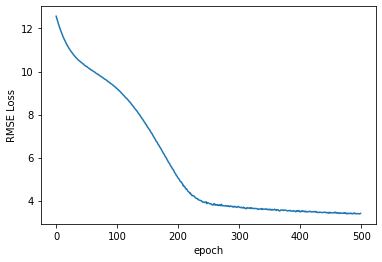

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: nan
